In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
import sys; sys.path.insert(0, '../')
from esinet.forward import create_forward_model, get_info
import os
from dipoleDataset import DipoleDataset
from util import eeg_to_Epochs
import torch
from esinet.evaluate import eval_auc, eval_nmse, eval_mse, eval_mean_localization_error
import json
from mne.beamformer import make_lcmv, apply_lcmv
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#reading the forward solution
fs = 100
info = get_info(sfreq=fs)
fwd = create_forward_model(sampling='ico4', info=info)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:    5.1s remaining:   17.4s
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:    5.2s remaining:    6.7s
[Parallel(n_jobs=-1)]: Done  52 out of  80 | elapsed:    5.2s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    5.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  80 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  35 out of  80 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  52 out of  80 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  69 out of  80 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 80

In [3]:
data_dir = "/mnt/data/convdip/training_data/"
eeg_data_dir = os.path.join(data_dir, "eeg_data")
interp_data_dir = os.path.join(data_dir, "interp_data")
source_data_dir = os.path.join(data_dir, "source_data")
info_path = os.path.join(data_dir, "info.fif")
dataset = DipoleDataset(eeg_data_dir, interp_data_dir, source_data_dir, info_path)
test_size = 0.15
val_size = 0.15

test_amount, val_amount = int(dataset.__len__() * test_size), int(dataset.__len__() * val_size)

# this function will automatically randomly split your dataset but you could also implement the split yourself
gen = torch.Generator()
gen.manual_seed(0)
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [
            (dataset.__len__() - (test_amount + val_amount)), 
            test_amount, 
            val_amount
])

B = 512  # batch size
train_dataloader = torch.utils.data.DataLoader(
            train_set,
            batch_size=B,
            shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
            val_set,
            batch_size=B,
            shuffle=True,
)
test_dataloader = torch.utils.data.DataLoader(
            test_set,
            batch_size=B,
            shuffle=True,
)

In [4]:
dipole_pos = np.load(os.path.join(data_dir, "dipole_pos.npy"))

In [ ]:
eeg_trials = []
targets = []
idxs = []
for i, data in enumerate(test_dataloader.dataset):
    idx, _, target = data
    eeg_trials.append(np.load(os.path.join(eeg_data_dir,f"sample_{idx}.npy")))
    idxs.append(idx)
    targets.append(target)
epochs = eeg_to_Epochs(eeg_trials, None, info)


    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 60
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 1025
[done]
    Created an SSP operator (subspace dimension = 1)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 61 -> 60
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 2091
[done]
Computing rank from covariance with rank=None
    Using tolerance 9.9e-11 (2.2e-16 eps * 61 dim * 7.3e+03  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 0 projectors


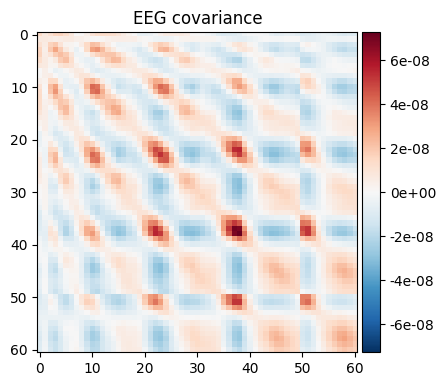

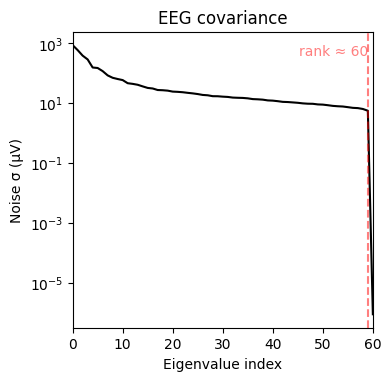

(<Figure size 380x370 with 2 Axes>, <Figure size 380x370 with 1 Axes>)

In [ ]:
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=0.25,
                                  method='empirical')

noise_cov = mne.compute_covariance(
    epochs, tmin=-0.2, tmax=0.5, method='empirical', rank=None, verbose=True)


In [ ]:
filters = make_lcmv(info, fwd, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori=None,
                    weight_norm='unit-noise-gain', rank=None)

Computing rank from covariance with rank=None
    Using tolerance 5.7e-11 (2.2e-16 eps * 61 dim * 4.2e+03  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.9e-11 (2.2e-16 eps * 61 dim * 7.3e+03  max singular value)
    Estimated rank (eeg): 60
    EEG: rank 60 computed from 61 data channels with 0 projectors
Making LCMV beamformer with rank {'eeg': 60}


Computing inverse operator with 61 channels.
    61 out of 61 channels remain after picking
Selected 61 channels
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 1)
Computing rank from covariance with rank={'eeg': 60}
    Setting small EEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing beamformer filters for 5124 sources
Filter computation complete


In [28]:
evoked = epochs[1].average()
stc = apply_lcmv(evoked, filters)

In [ ]:
metrics_per_sample = {}
metric_save_path = "/mnt/data/convdip/LCMV_evaluation_metrics.json"

for i in range(len(epochs)):
    print(i)
    evoked = epochs[i].average()
    stc = apply_lcmv(evoked, filters)

    eeg = epochs[i].get_data(copy=False).squeeze()
    target = np.array(targets[i])
    
    max_idx = np.unravel_index(np.argmax(eeg), eeg.shape)[1] # this is the timestep with the maximum eeg value, this will be used to train
    s_at_max = stc.data[:,max_idx]

    auc_close, auc_far = eval_auc(target, s_at_max, dipole_pos)
    sample_auc = (auc_close + auc_far)/2
    
    mle = eval_mean_localization_error(target, s_at_max, dipole_pos)
    mse = eval_mse(target, s_at_max)
    nmse = eval_nmse(target, s_at_max)
    metrics_per_sample[idxs[i]] = [auc_close, auc_far, mle, mse, nmse]

    if i % 512 == 0:
        with open(metric_save_path, "w") as json_file:
            json.dump(metrics_per_sample, json_file)

  0%|          | 0/41 [00:00<?, ?it/s]

100%|██████████| 41/41 [01:13<00:00,  1.79s/it]
